# Solving the Wholesale Customer Segmentation problem using Hierarchical Agglomerative Clustering

#### the wholesale customer dataset at https://archive.ics.uci.edu/ml/datasets/wholesale+customers. The dataset refers to clients of a wholesale distributor.

It contains 440 observations and 8 variable.

Attribute Information:

    1) FRESH: annual spending (m.u.) on fresh products (Continuous);
    2) MILK: annual spending (m.u.) on milk products (Continuous);
    3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
    4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
    5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
    6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
    7) CHANNEL: customers Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal)
    8) REGION: customers Region - Lisnon, Oporto or Other (Nominal) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"

In [3]:
raw_data = pd.read_csv(url, index_col= None, na_values='?')
raw_data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


#### the first two variables are factors (categorical variables) representing the location and channel of purchase.

In [4]:
# first glance of customers_orders data
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [5]:
# Total missing values, NA, for each feature
print (raw_data.isnull().sum() )

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


In [6]:
raw_data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [7]:
# excluding the non-useful columns from the dataset
cust_data = raw_data.iloc[:,2:]
cust_data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


### Display data

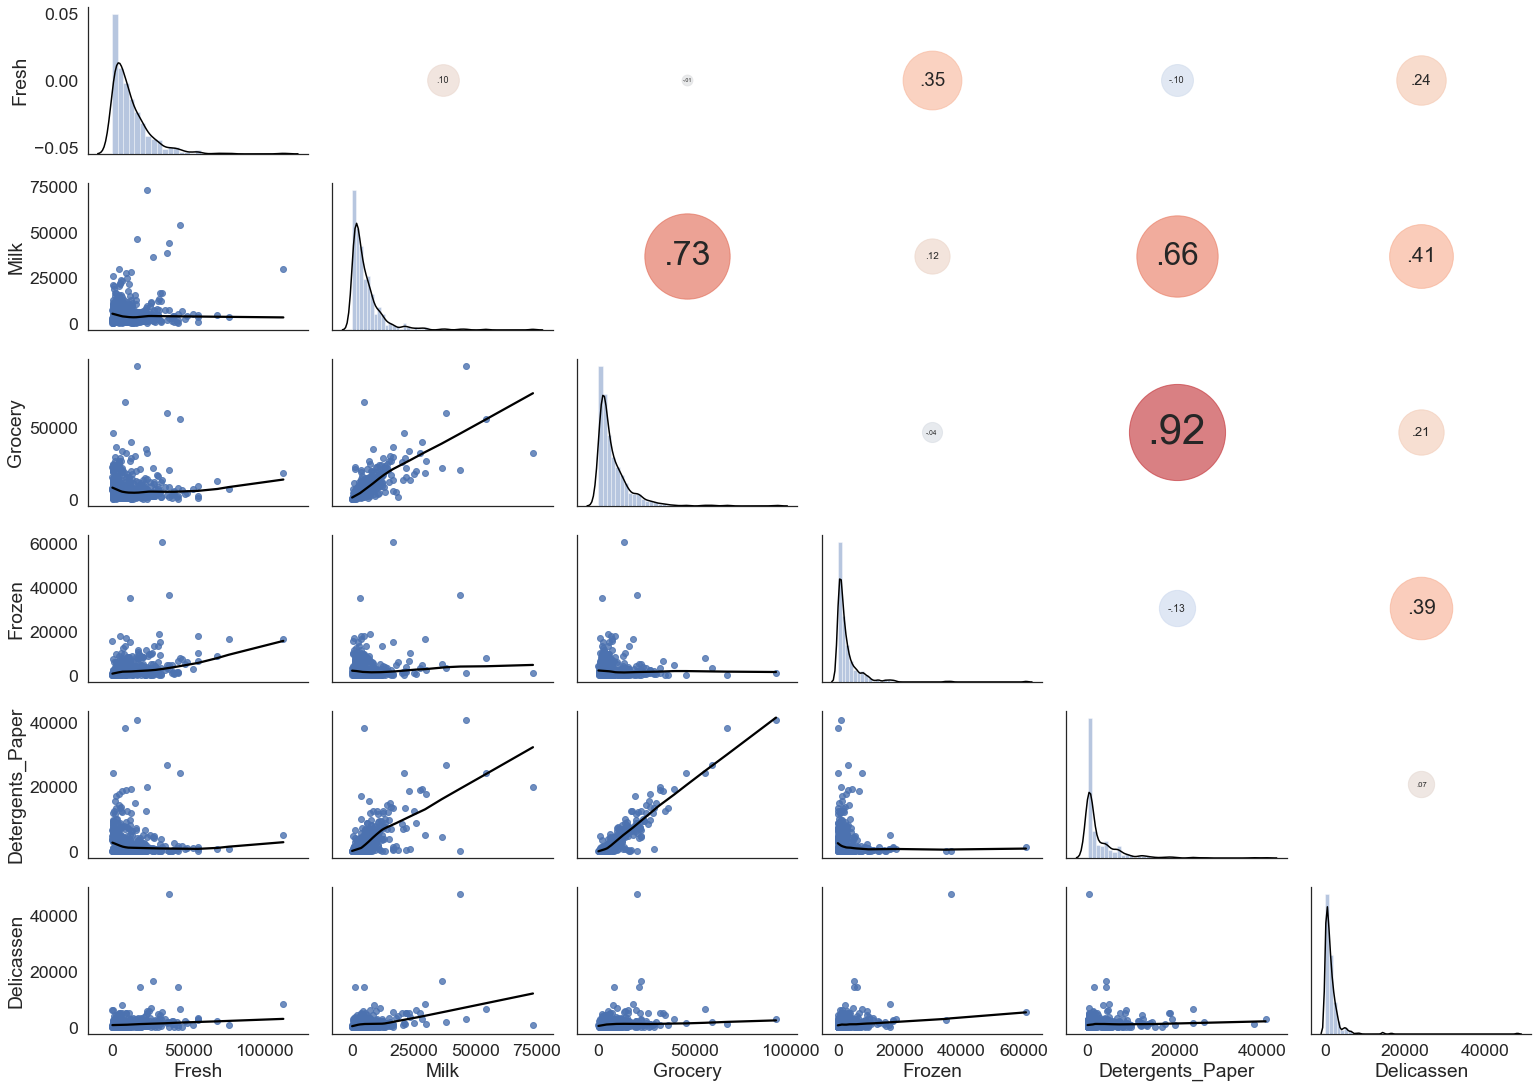

In [8]:
# https://stackoverflow.com/questions/48139899/correlation-matrix-plot-with-coefficients-on-one-side-scatterplots-on-another
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(cust_data, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

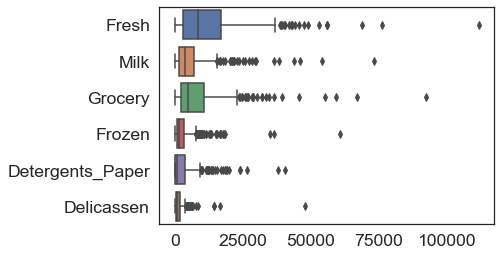

In [9]:
sns.boxplot(data= cust_data, orient="h")

In [10]:
# Scaling data and bring all the variables to the same scale:

#scaler = MinMaxScaler()
scaler = RobustScaler() #  it is robust to outliers. see https://stackoverflow.com/questions/51841506/data-standardization-vs-normalization-vs-robust-scaler
scaled_data = scaler.fit_transform(cust_data)
scaled_data = pd.DataFrame(scaled_data, columns=cust_data.columns)
scaled_data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.301680,1.065712,0.329952,-0.466572,0.506787,0.263810
1,-0.104810,1.092934,0.565993,0.083926,0.675670,0.574008
2,-0.155802,0.915816,0.344418,0.312589,0.736512,4.871459
3,0.344850,-0.429714,-0.062862,1.734708,-0.084442,0.582507
4,1.022092,0.315171,0.287260,0.849573,0.262056,2.988314


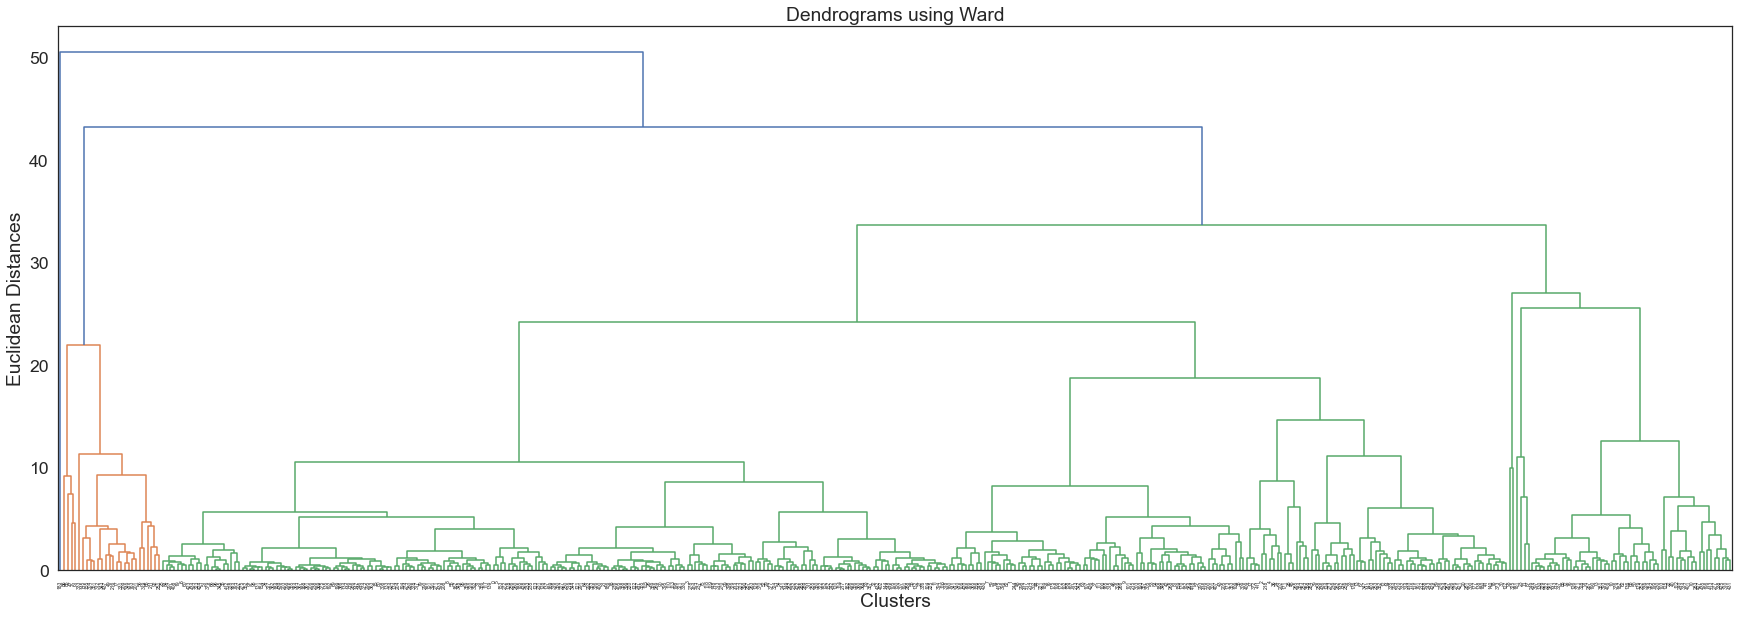

In [11]:
# Let’s first draw the dendrogram to help us decide the number of clusters for this particular problem:
plt.figure(figsize=(30, 10))  
plt.title("Dendrograms using Ward")  
dend = sch.dendrogram(sch.linkage(scaled_data, method='ward', metric='euclidean'))
plt.xlabel('Clusters')
plt.ylabel('Euclidean Distances')
plt.show()

https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019
Dendrograms  

We can use a dendrogram to visualize the history of groupings and figure out the optimal number of clusters.

    1. Determine the largest vertical distance that doesn’t intersect any of the other clusters
    2. Draw a horizontal line at both extremities
    3. The optimal number of clusters is equal to the number of vertical lines going through the horizontal line

#### Let's CLuster Our Data Using Agglomerative Clustering

In [12]:
# visual has number of cluster = 3
agg_clu = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
agg_clu.fit_predict(scaled_data)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Text(0, 0.5, 'Milk')

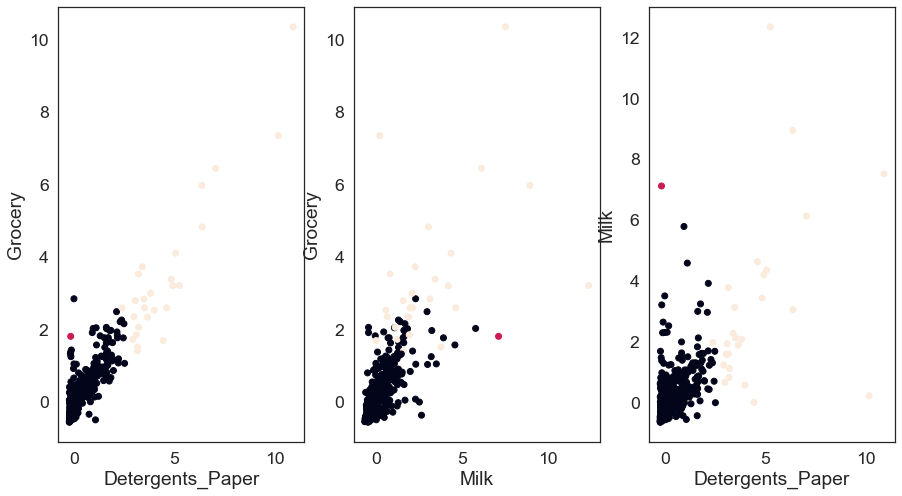

In [13]:
plt.figure(figsize=(15, 8))  
ax1 = plt.subplot2grid((1, 3), (0, 0))
plt.scatter(scaled_data['Detergents_Paper'], scaled_data['Grocery'], c=agg_clu.labels_) 
ax1.set_xlabel("Detergents_Paper")
ax1.set_ylabel("Grocery")
ax2 = plt.subplot2grid((1, 3), (0, 1))
plt.scatter(scaled_data['Milk'], scaled_data['Grocery'], c=agg_clu.labels_) 
ax2.set_xlabel("Milk")
ax2.set_ylabel("Grocery")
ax3 = plt.subplot2grid((1, 3), (0, 2))
plt.scatter(scaled_data['Detergents_Paper'], scaled_data['Milk'], c=agg_clu.labels_) 
ax3.set_xlabel("Detergents_Paper")
ax3.set_ylabel("Milk")


silhouette_score: 56.70005061624909


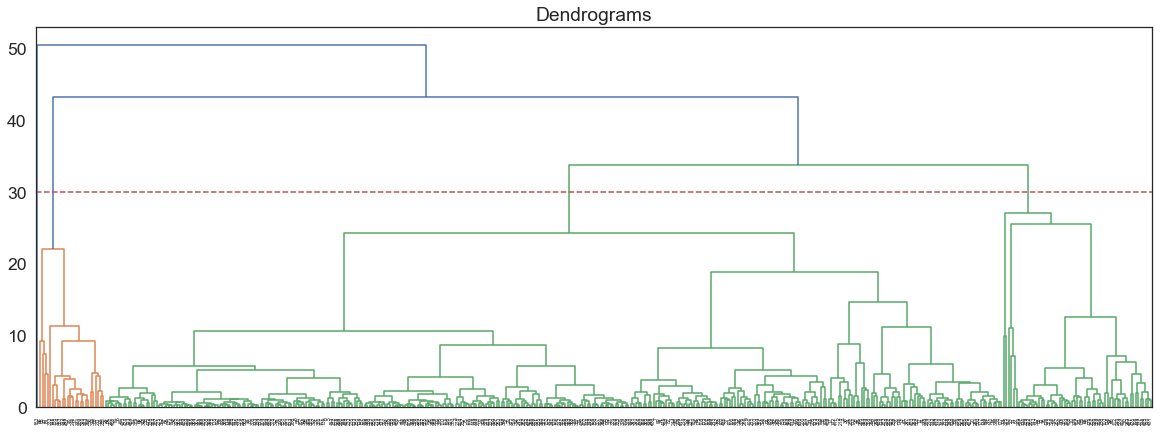

In [14]:
# Get Prediction and evaluate model
y_hc = agg_clu.fit_predict(scaled_data)

# Evaluate the model for 5 clusters
print("silhouette_score:" ,silhouette_score(scaled_data, y_hc) * 100)

# let set the thereshold value 23  or 26 to cut the graph
plt.figure(figsize=(20, 7))  
plt.title("Dendrograms")  
dend = sch.dendrogram(sch.linkage(scaled_data, method='ward', metric='euclidean'))
plt.axhline(y=30, color='r', linestyle='--') # for 3 clusters
plt.show()

### Fitting new data points into existing clusters

In [15]:
df_hc = pd.DataFrame(raw_data)
df_hc['Cluster'] = y_hc
df_hc.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,2,3,12669,9656,7561,214,2674,1338,0
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,0
4,2,3,22615,5410,7198,3915,1777,5185,0


In [16]:
pd.crosstab(df_hc['Cluster'], df_hc['Channel'])

Channel,1,2
Cluster,,
0,297,116
1,1,0
2,0,26


#### 2 Clusters has highest silhouette score

In [17]:
for i in range (2,10,1):
    agg_clu2 = AgglomerativeClustering(i, affinity='euclidean', linkage='ward')  
    y_hc2 = agg_clu2.fit_predict(scaled_data)
    print("Number of cluster: {} has silhouette_score= {}".format(i, silhouette_score(scaled_data, y_hc2) ))

Number of cluster: 2 has silhouette_score= 0.9032151582400334
Number of cluster: 3 has silhouette_score= 0.5670005061624909
Number of cluster: 4 has silhouette_score= 0.40824012277524807
Number of cluster: 5 has silhouette_score= 0.38074001073887304
Number of cluster: 6 has silhouette_score= 0.3386923395988653
Number of cluster: 7 has silhouette_score= 0.26434550905577886
Number of cluster: 8 has silhouette_score= 0.27137704645196303
Number of cluster: 9 has silhouette_score= 0.28982112612901384
